In [ ]:
from google.colab import files
uploaded = files.upload()


Saving CityTrafficData.csv to CityTrafficData.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import shutil

# Source = uploaded file
source_file = list(uploaded.keys())[0]

# Destination path inside your Drive
dest_path = "/content/drive/MyDrive/CityTrafficData.csv"

# Copy file to Drive
shutil.copy(source_file, dest_path)

print(f"File '{source_file}' uploaded and saved to {dest_path}")


Mounted at /content/drive
File 'CityTrafficData.csv' uploaded and saved to /content/drive/MyDrive/CityTrafficData.csv


In [ ]:
# ===================== OPTIMIZED TRAFFIC MODEL ===================== #
# Trains Random Forest + Hyperparameter Tuning + Saves Model
# --------------------------------------------------------------- #

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib
import warnings
warnings.filterwarnings("ignore")

# -------------------- PREPROCESSING FUNCTION -------------------- #
def preprocess_data(path):
    data = pd.read_csv(path)

    # Encode categorical columns
    data['Traffic Situation'] = data['Traffic Situation'].replace({'low': 1, 'normal': 2, 'high': 3, 'heavy': 4})
    data['Day of the week'] = data['Day of the week'].replace({
        'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
        'Friday': 5, 'Saturday': 6, 'Sunday': 7
    })
    data['Weather'] = data['Weather'].replace({'Sunny': 1, 'Rainy': 2, 'Foggy': 3})
    data['RoadType'] = data['RoadType'].replace({'Highway': 1, 'CityRoad': 2, 'NarrowRoad': 3})
    data['Holiday'] = data['Holiday'].replace({'No': 0, 'Yes': 1})

    data['hour'] = pd.to_datetime(data['Time']).dt.hour
    data['minute'] = pd.to_datetime(data['Time']).dt.minute
    data['AM/PM'] = (data['Time'].str.split().str[1] == 'PM').astype(int)
    data = data.drop(columns=['Time'], axis=1)

    X = data[['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
              'TruckCount', 'Total', 'hour', 'minute', 'AM/PM', 'Weather', 'RoadType', 'Holiday']]
    y = data['Traffic Situation']

    return X, y


# -------------------- TRAINING FUNCTION -------------------- #
def train_optimized_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    param_grid = {
        'n_estimators': [100, 150],
        'max_depth': [8, 10, 12],
        'min_samples_split': [2, 4],
        'min_samples_leaf': [1, 2]
    }

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)

    print("✅ Training complete!")
    print("Best Parameters:", grid.best_params_)
    print(f"Optimized Model Accuracy: {acc*100:.2f}%")

    return best_model, scaler


# -------------------- SAVE MODEL -------------------- #
def save_model(model, scaler):
    joblib.dump(model, 'Optimized_Traffic_Model.pkl')
    joblib.dump(scaler, 'Traffic_Scaler.pkl')
    print("💾 Model and Scaler saved successfully!")


# -------------------- MAIN -------------------- #
def main():
    X, y = preprocess_data('CityTrafficData.csv')
    best_model, scaler = train_optimized_model(X, y)
    save_model(best_model, scaler)


if __name__ == "__main__":
    main()


✅ Training complete!
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Optimized Model Accuracy: 99.32%
💾 Model and Scaler saved successfully!


In [ ]:
# ===================== HEURISTIC MODULE ===================== #
# Helper functions for Smart Route Optimization
# ------------------------------------------------------------ #

import math

def euclidean_heuristic(node_a, node_b, coordinates):
    (x1, y1) = coordinates[node_a]
    (x2, y2) = coordinates[node_b]
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return round(distance, 2)

def traffic_cost_weight(traffic_level, weather_factor=1.0, road_quality=1.0):
    base = {1: 1.0, 2: 1.5, 3: 2.0, 4: 3.0}
    traffic_level = base.get(traffic_level, 2)
    return round(traffic_level * weather_factor * road_quality, 2)

def heuristic_summary():
    print("📘 Heuristic Summary:")
    print("- Euclidean heuristic estimates distance between cities.")
    print("- Traffic level multiplies distance by severity weight.")
    print("- Weather and road quality further scale the cost.")
    print("- Overall cost ≈ Distance × (Traffic × Weather × RoadType)")


In [ ]:
# --- Create HeuristicModule.py automatically ---
heuristic_code = """
import math

def euclidean_heuristic(node_a, node_b, coordinates):
    (x1, y1) = coordinates[node_a]
    (x2, y2) = coordinates[node_b]
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return round(distance, 2)

def traffic_cost_weight(traffic_level, weather_factor=1.0, road_quality=1.0):
    base = {1: 1.0, 2: 1.5, 3: 2.0, 4: 3.0}
    traffic_level = base.get(traffic_level, 2)
    return round(traffic_level * weather_factor * road_quality, 2)

def heuristic_summary():
    print("📘 Heuristic Summary:")
    print("- Euclidean heuristic estimates distance between cities.")
    print("- Traffic level multiplies distance by severity weight.")
    print("- Weather and road quality further scale the cost.")
    print("- Overall cost ≈ Distance × (Traffic × Weather × RoadType)")
"""

with open("HeuristicModule.py", "w") as f:
    f.write(heuristic_code)

print("✅ HeuristicModule.py created successfully.")


✅ HeuristicModule.py created successfully.


In [ ]:
def traffic_cost_weight(traffic_level, weather, road_type, holiday):
    """
    Returns a dynamic cost multiplier based on:
    - Traffic level (1–4)
    - Weather condition
    - Road type
    - Holiday effect
    """
    # Base traffic weights
    traffic_weights = {1: 1.0, 2: 1.4, 3: 1.8, 4: 2.5}
    traffic_factor = traffic_weights.get(traffic_level, 1.0)

    # Weather impact
    weather_effect = {"Sunny": 1.0, "Cloudy": 1.1, "Rainy": 1.3}
    weather_factor = weather_effect.get(weather, 1.0)

    # Road type impact
    road_effect = {"Highway": 0.9, "CityRoad": 1.1, "NarrowRoad": 1.3}
    road_factor = road_effect.get(road_type, 1.0)

    # Holiday effect
    holiday_factor = 0.9 if holiday else 1.0

    # Combine all effects
    total_weight = traffic_factor * weather_factor * road_factor * holiday_factor
    return total_weight



--- Scenario: Weather: Sunny | Time: 08:00:00 | Weekday ---
Best Route Found: A -> C -> D
Total Weighted Cost: 10.50


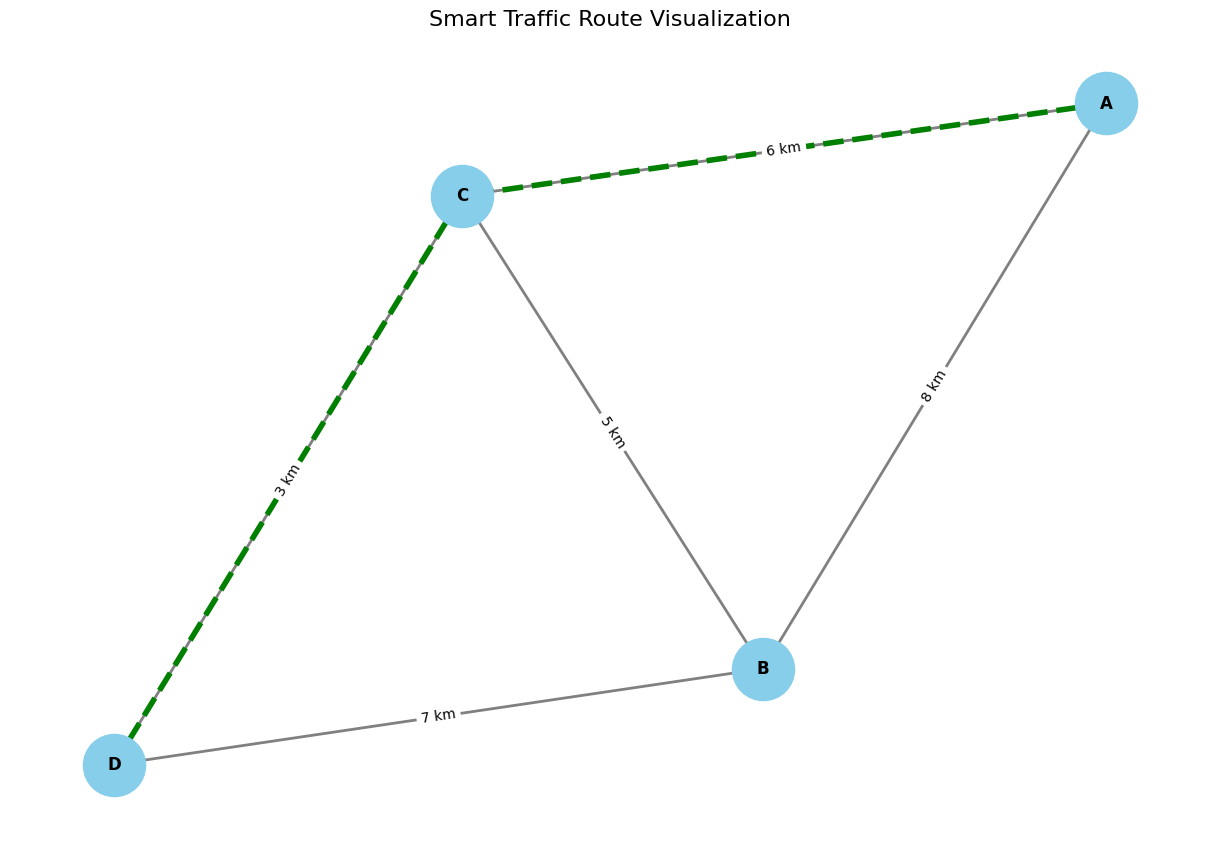


--- Scenario: Weather: Cloudy | Time: 12:30:00 | Weekday ---
Best Route Found: A -> C -> D
Total Weighted Cost: 11.55


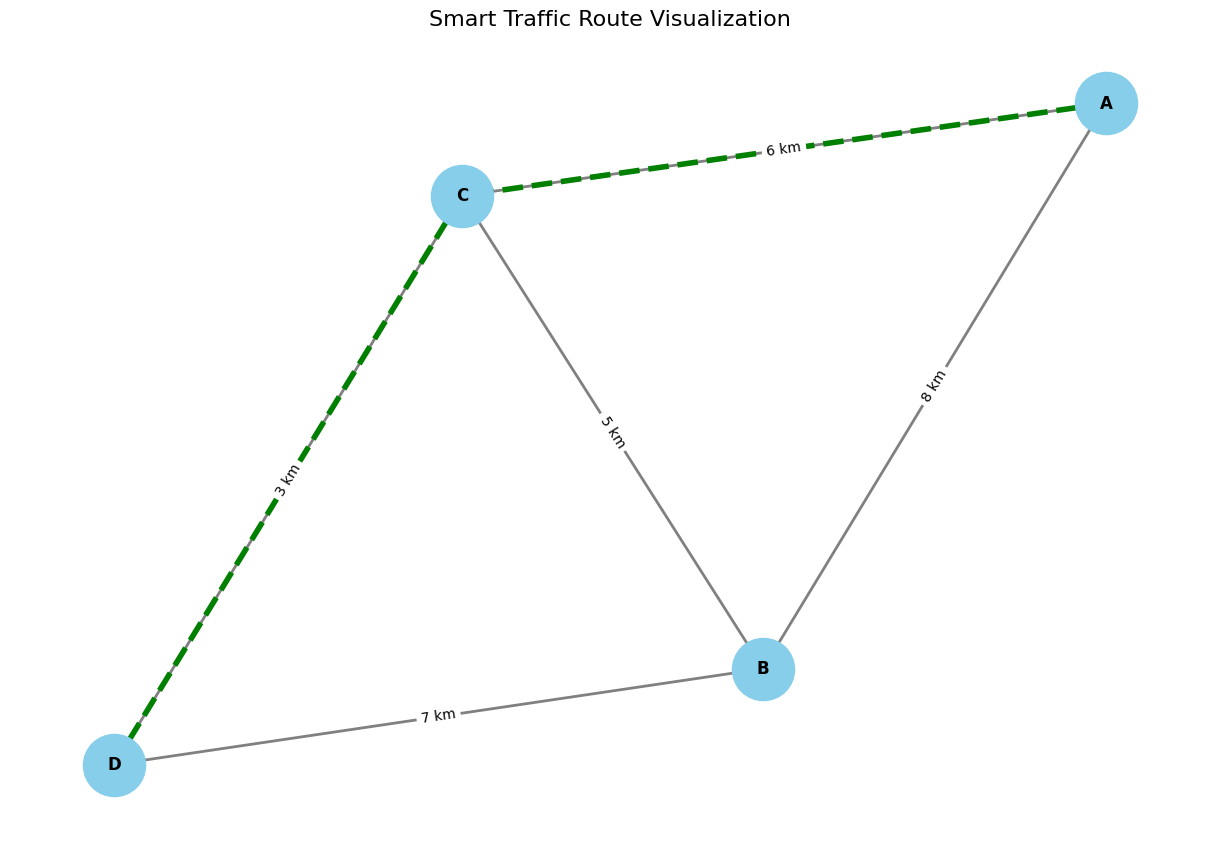


--- Scenario: Weather: Rainy | Time: 17:45:00 | Holiday ---
Best Route Found: A -> C -> D
Total Weighted Cost: 17.64


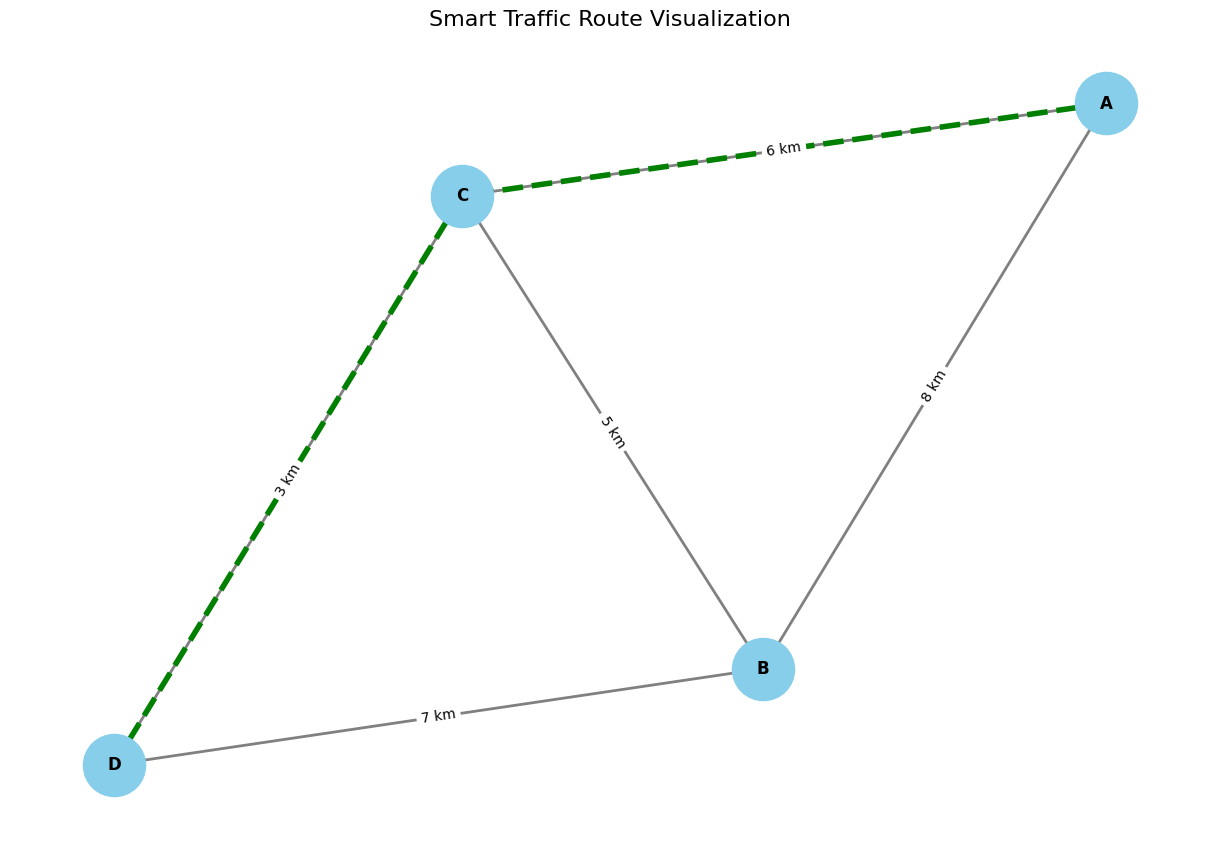


--- Scenario: Weather: Sunny | Time: 22:00:00 | Weekday ---
Best Route Found: A -> C -> D
Total Weighted Cost: 10.50


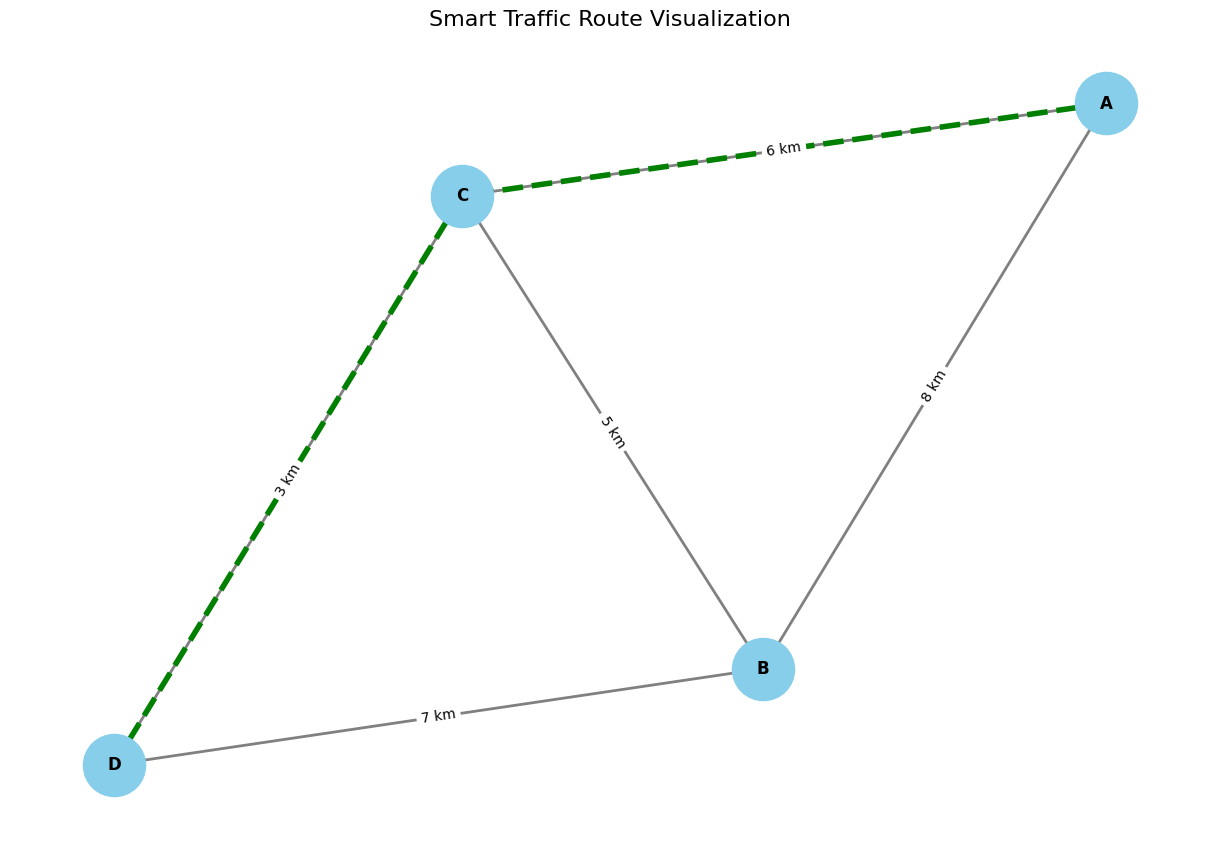

In [ ]:
import pandas as pd
import networkx as nx
import heapq
import matplotlib.pyplot as plt
import joblib
import os
import warnings

warnings.filterwarnings("ignore")

def traffic_cost_weight(traffic_level, weather, road_type, holiday):
    """
    Calculates a heuristic cost weight based on multiple factors.
    This function replaces the need for the external HeuristicModule.py file.
    """
    # Base weight from traffic level
    traffic_weights = {1: 1.0, 2: 1.5, 3: 2.5, 4: 4.0} # Low, Normal, High, Heavy
    base_weight = traffic_weights.get(traffic_level, 1.0)

    # Adjust weight based on weather
    weather_multiplier = {"Sunny": 1.0, "Cloudy": 1.1, "Rainy": 1.4}
    base_weight *= weather_multiplier.get(weather, 1.0)

    # Adjust weight based on road type
    road_type_multiplier = {"Highway": 0.9, "CityRoad": 1.1, "NarrowRoad": 1.3}
    base_weight *= road_type_multiplier.get(road_type, 1.0)

    # Add a penalty for holidays
    if holiday:
        base_weight *= 1.2

    return base_weight


class SmartRoutePlanner:
    def __init__(self, model_path, scaler_path):
        # Verify model and scaler existence
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model not found at {model_path}. Please upload it to your Colab session.")
        if not os.path.exists(scaler_path):
            raise FileNotFoundError(f"Scaler not found at {scaler_path}. Please upload it to your Colab session.")

        # Load trained model and scaler
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.graph = nx.Graph()

    def add_road(self, a, b, distance, vehicles, road_type):
        """Adds bidirectional road (edge) between two nodes."""
        self.graph.add_edge(a, b, distance=distance, vehicles=vehicles, road_type=road_type)

    def predict_traffic(self, day, time, vehicles, weather, road_type, holiday):
        """Predicts traffic level using trained Random Forest model."""
        hour, minute, _ = map(int, time.split(":"))
        am_pm = 1 if hour >= 12 else 0
        hour = hour % 12
        total = sum(vehicles.values())

        input_data = pd.DataFrame([[
            0, day,
            vehicles["cars"], vehicles["bikes"], vehicles["buses"], vehicles["trucks"],
            total, hour, minute, am_pm,
            {"Sunny": 1, "Cloudy": 2, "Rainy": 3}[weather],
            {"Highway": 1, "CityRoad": 2, "NarrowRoad": 3}[road_type],
            int(holiday)
        ]], columns=['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount',
                     'Total', 'hour', 'minute', 'AM/PM', 'Weather', 'RoadType', 'Holiday'])

        input_scaled = self.scaler.transform(input_data)
        return self.model.predict(input_scaled)[0]

    def calculate_cost(self, a, b, day, time, weather, holiday):
        """Calculates edge cost dynamically using model + heuristic factors."""
        edge = self.graph[a][b]
        distance = edge['distance']
        vehicles = edge['vehicles']
        road_type = edge['road_type']

        # Predict traffic level for this edge
        traffic_level = self.predict_traffic(day, time, vehicles, weather, road_type, holiday)

        # Compute final cost with all adjustment factors
        weight = traffic_cost_weight(traffic_level, weather, road_type, holiday)
        total_cost = distance * weight
        return total_cost, traffic_level

    def find_best_route(self, start, goal, day, time, weather, holiday):
        """Finds least-cost route using modified Dijkstra / A* algorithm."""
        pq = [(0, start, [])]
        seen = {}

        while pq:
            cost, node, path = heapq.heappop(pq)
            if node in seen and seen[node] <= cost:
                continue
            seen[node] = cost

            if node == goal:
                return path + [node], cost

            for nbr in self.graph.neighbors(node):
                if nbr in path: # Avoid cycles
                    continue
                edge_cost, _ = self.calculate_cost(node, nbr, day, time, weather, holiday)
                new_cost = cost + edge_cost
                heapq.heappush(pq, (new_cost, nbr, path + [node]))

        return None, float('inf')

    def visualize(self, best_path):
        """Draws the road network and highlights optimal route."""
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(self.graph, seed=42)
        nx.draw(self.graph, pos, with_labels=True, node_color='skyblue',
                node_size=2000, edge_color='gray', width=2, font_size=12, font_weight='bold')

        if best_path:
            path_edges = list(zip(best_path[:-1], best_path[1:]))
            nx.draw_networkx_edges(self.graph, pos, edgelist=path_edges,
                                   edge_color='green', width=4, style='dashed')

        edge_labels = nx.get_edge_attributes(self.graph, 'distance')
        edge_labels = {e: f"{d} km" for e, d in edge_labels.items()}
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=edge_labels, font_size=10)

        plt.title("Smart Traffic Route Visualization", size=16)
        plt.axis('off')
        plt.show()


def main():
    # Define the paths for your model and scaler files
    model_path = "Optimized_Traffic_Model.pkl"
    scaler_path = "Traffic_Scaler.pkl"

    # Important: Ensure these files are uploaded to your Colab session!
    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print("---")
        print(f"ERROR: Make sure '{model_path}' and '{scaler_path}' are uploaded to your Colab session.")
        print("Click the folder icon on the left, then click the 'Upload' button.")
        print("---")
        return

    # Initialize planner
    planner = SmartRoutePlanner(model_path, scaler_path)

    # Add roads (city connections)
    planner.add_road("A", "B", 8, {"cars": 40, "bikes": 30, "buses": 8, "trucks": 5}, "Highway")
    planner.add_road("A", "C", 6, {"cars": 35, "bikes": 25, "buses": 5, "trucks": 4}, "CityRoad")
    planner.add_road("B", "D", 7, {"cars": 30, "bikes": 40, "buses": 6, "trucks": 7}, "CityRoad")
    planner.add_road("C", "D", 3, {"cars": 25, "bikes": 35, "buses": 5, "trucks": 3}, "NarrowRoad")
    planner.add_road("B", "C", 5, {"cars": 20, "bikes": 20, "buses": 3, "trucks": 2}, "Highway")

    # Define test scenarios
    scenarios = [
        ("08:00:00", "Sunny", 0),      # Morning rush, good weather
        ("12:30:00", "Cloudy", 0),     # Midday, cloudy
        ("17:45:00", "Rainy", 1),      # Evening rush, rainy, holiday
        ("22:00:00", "Sunny", 0)       # Late night, good weather
    ]

    for t, w, h in scenarios:
        path, cost = planner.find_best_route("A", "D", 5, t, w, h) # Day 5 = Friday
        print(f"\n--- Scenario: Weather: {w} | Time: {t} | {'Holiday' if h else 'Weekday'} ---")
        if path:
            print(f"Best Route Found: {' -> '.join(path)}")
            print(f"Total Weighted Cost: {cost:.2f}")
            planner.visualize(path)
        else:
            print("No valid route was found for this scenario.")


if __name__ == "__main__":
    main()

In [ ]:
# ===================== TRAFFIC ML TRAINER ===================== #
# Standalone ML Testing Script
# --------------------------------------------------------------- #

import pandas as pd
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

# Load trained model and scaler
model = joblib.load("Optimized_Traffic_Model.pkl")
scaler = joblib.load("Traffic_Scaler.pkl")

# Mappings
weather_map = {'Sunny': 1, 'Rainy': 2, 'Foggy': 3}
road_map = {'Highway': 1, 'CityRoad': 2, 'NarrowRoad': 3}
traffic_map = {1: "🟢 Low", 2: "🟡 Normal", 3: "🟠 High", 4: "🔴 Heavy"}

# Test cases (automatic, no manual input)
test_cases = [
    {"Day": 1, "Time": "08:00:00", "Cars": 180, "Bikes": 130, "Buses": 8, "Trucks": 15,
     "Weather": "Sunny", "RoadType": "Highway", "Holiday": 0},
    {"Day": 3, "Time": "12:30:00", "Cars": 280, "Bikes": 210, "Buses": 12, "Trucks": 25,
     "Weather": "Rainy", "RoadType": "CityRoad", "Holiday": 0},
    {"Day": 5, "Time": "18:00:00", "Cars": 310, "Bikes": 240, "Buses": 15, "Trucks": 30,
     "Weather": "Foggy", "RoadType": "NarrowRoad", "Holiday": 1},
    {"Day": 7, "Time": "22:00:00", "Cars": 150, "Bikes": 110, "Buses": 5, "Trucks": 10,
     "Weather": "Sunny", "RoadType": "Highway", "Holiday": 1},
]

# Predict for each case
print("🚦 Traffic Prediction Summary:\n" + "=" * 65)
for i, case in enumerate(test_cases, 1):
    hour, minute, second = map(int, case["Time"].split(":"))
    am_pm = 1 if hour >= 12 else 0
    hour = hour % 12
    total = case["Cars"] + case["Bikes"] + case["Buses"] + case["Trucks"]

    df = pd.DataFrame([[
        0, case["Day"], case["Cars"], case["Bikes"], case["Buses"], case["Trucks"],
        total, hour, minute, am_pm,
        weather_map[case["Weather"]], road_map[case["RoadType"]], case["Holiday"]
    ]], columns=['Date', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount',
                 'TruckCount', 'Total', 'hour', 'minute', 'AM/PM', 'Weather', 'RoadType', 'Holiday'])

    pred = model.predict(scaler.transform(df))[0]
    prob = model.predict_proba(scaler.transform(df))[0]
    confidence = np.max(prob) * 100

    print(f"\nCase {i}: Day {case['Day']} | {case['Weather']} | {case['RoadType']} | {'Holiday' if case['Holiday'] else 'Weekday'}")
    print(f"Time: {case['Time']} | Vehicles: {total}")
    print(f"Predicted Traffic: {traffic_map[pred]} ({pred}) | Confidence: {confidence:.2f}%")



🚦 Traffic Prediction Summary:

Case 1: Day 1 | Sunny | Highway | Weekday
Time: 08:00:00 | Vehicles: 333
Predicted Traffic: 🟠 High (3) | Confidence: 89.28%

Case 2: Day 3 | Rainy | CityRoad | Weekday
Time: 12:30:00 | Vehicles: 527
Predicted Traffic: 🔴 Heavy (4) | Confidence: 98.00%

Case 3: Day 5 | Foggy | NarrowRoad | Holiday
Time: 18:00:00 | Vehicles: 595
Predicted Traffic: 🔴 Heavy (4) | Confidence: 95.33%

Case 4: Day 7 | Sunny | Highway | Holiday
Time: 22:00:00 | Vehicles: 275
Predicted Traffic: 🟡 Normal (2) | Confidence: 89.89%


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("CityTrafficData.csv")

# Drop target/output column (Traffic Situation)
features = df.drop(columns=["Traffic Situation"])

# Print details
print("Feature Columns:")
print(list(features.columns))
print("\nTotal Number of Features:", features.shape[1])


Feature Columns:
['Date', 'Day of the week', 'Time', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Weather', 'RoadType', 'Holiday']

Total Number of Features: 11


In [ ]:
import pandas as pd

# Load your dataset
df = pd.read_csv("CityTrafficData.csv")

# Display dataset shape and size info
print("✅ Dataset Loaded Successfully!\n")

print(f"Total Rows (records): {df.shape[0]}")
print(f"Total Columns (features): {df.shape[1]}")
print("\nColumn Names:")
print(list(df.columns))

# Optional: show first few rows
print("\nFirst 5 rows:")
print(df.head())


✅ Dataset Loaded Successfully!

Total Rows (records): 1470
Total Columns (features): 12

Column Names:
['Date', 'Day of the week', 'Time', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Weather', 'RoadType', 'Holiday', 'Traffic Situation']

First 5 rows:
   Date Day of the week      Time  CarCount  BikeCount  BusCount  TruckCount  \
0     1          Monday  08:00 AM       131        177         6          31   
1     1          Monday  10:00 AM       206        213         2          16   
2     1          Monday  12:00 PM       336         29         2          27   
3     1          Monday  02:00 PM       114        215        12          16   
4     1          Monday  04:00 PM       351        117         8           8   

   Total Weather    RoadType Holiday Traffic Situation  
0    345   Rainy     Highway     Yes              high  
1    437   Foggy     Highway      No              high  
2    394   Rainy  NarrowRoad      No              high  
3    357   Sunny  Narr


🔍 Random Forest Accuracy Comparison

 Trees  Max Depth  Accuracy (%)
    50          8        100.00
   100         10        100.00
   150         12        100.00
   200         15        100.00
   250         20         99.66


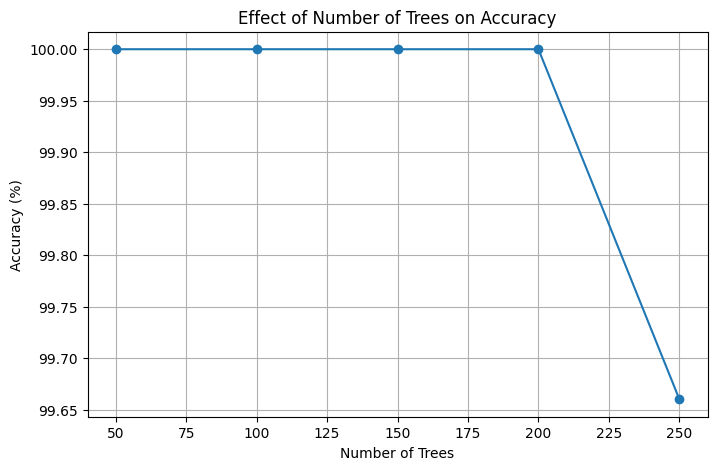

In [ ]:
# ===================== RANDOM FOREST ACCURACY COMPARISON ===================== #
# Compares performance for different numbers of trees and depths
# ----------------------------------------------------------------------------- #

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# -------------------- LOAD AND PREPROCESS DATA -------------------- #
df = pd.read_csv("CityTrafficData.csv")

# Encode categorical columns
df['Traffic Situation'] = df['Traffic Situation'].replace({'low': 1, 'normal': 2, 'high': 3, 'heavy': 4})
df['Day of the week'] = df['Day of the week'].replace({
    'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4,
    'Friday': 5, 'Saturday': 6, 'Sunday': 7
})
df['Weather'] = df['Weather'].replace({'Sunny': 1, 'Rainy': 2, 'Foggy': 3})
df['RoadType'] = df['RoadType'].replace({'Highway': 1, 'CityRoad': 2, 'NarrowRoad': 3})
df['Holiday'] = df['Holiday'].replace({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0}).astype(int)

# Extract time features
df['hour'] = pd.to_datetime(df['Time']).dt.hour
df['minute'] = pd.to_datetime(df['Time']).dt.minute
df['AM/PM'] = (df['hour'] >= 12).astype(int)

# Drop unused columns
df = df.drop(columns=['Time', 'Date'])

# Split data
X = df.drop(columns=['Traffic Situation'])
y = df['Traffic Situation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------- TEST DIFFERENT CONFIGURATIONS -------------------- #
param_combinations = [
    {'n_estimators': 50, 'max_depth': 8},
    {'n_estimators': 100, 'max_depth': 10},
    {'n_estimators': 150, 'max_depth': 12},
    {'n_estimators': 200, 'max_depth': 15},
    {'n_estimators': 250, 'max_depth': 20}
]

results = []

for params in param_combinations:
    rf = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        random_state=42
    )
    rf.fit(X_train_scaled, y_train)
    preds = rf.predict(X_test_scaled)
    acc = accuracy_score(y_test, preds)
    results.append({
        'Trees': params['n_estimators'],
        'Max Depth': params['max_depth'],
        'Accuracy (%)': round(acc * 100, 2)
    })

# -------------------- DISPLAY RESULTS -------------------- #
results_df = pd.DataFrame(results)
print("\n🔍 Random Forest Accuracy Comparison\n")
print(results_df.to_string(index=False))

# Optional visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results_df['Trees'], results_df['Accuracy (%)'], marker='o')
plt.title('Effect of Number of Trees on Accuracy')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.show()
